In [2]:
from IPython.display import Image

## Thompson sampling

Hi! This is a report I have written on Thompson sampling. This was originally intended to be a presentation but since I didn't get a chance to present this in class, I have written this report. The presentation can be found as `presentation.Rpres`, but what I'm about to present here is pretty much the same thing. **Note: while this is an IPython notebook, the code I have written is actually R code, not Python.**

I am grateful to these lecture notes which provided an excellent introduction to the topic: https://bandits.wikischolars.columbia.edu/file/view/Lecture+4.pdf

### Introduction

If you recall, in the $k$-armed bandit problem we have $k$ levers that we can pull at each time step, $1, \dots, T$, which we denote as actions $a \in A$. Each action $a_{i} \in A$ gives us a reward drawn from some unknown distribution $r_{i} \sim p(r \ | \ A = a_{i})$, and the goal is to maximise the rewards $Q_{T} = \sum_{i=1}^{T} r_{i}$

Just like agent-based reinforcement learning, we are faced with the exploration vs exploitation dilemma. On one hand, we want to make sure we get the 'best' lever (need to 'explore', in order to gain confidence), but on the other hand, we want to make sure we get the best reward (need to 'exploit').

Before we start off explaining the idea behind Thompson sampling, we briefly go over one of the simplest bandit algorithms:

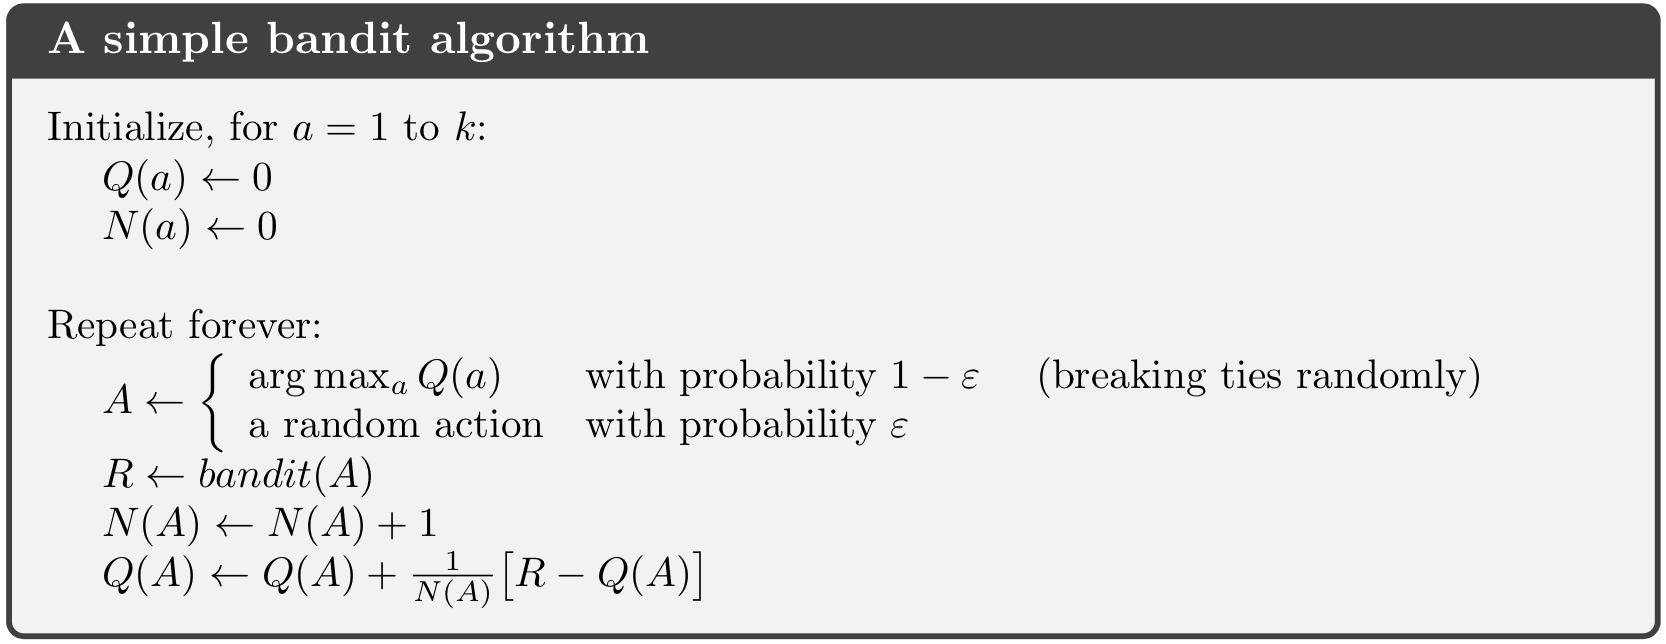

In [4]:
Image("./simple_bandit_algorithm.png", width=800)

Basically, all we do is keep an incremental mean of the reward gained for each lever, and at every time step, we choose the lever that has so far given us the highest mean reward. With probability $\epsilon$ however, we will decide to explore other levers, as our 'best' lever (the one with the highest mean reward) may not actually be the best lever!

### A simple example

Let us consider a 5-armed bandit problem, where $p(r \ | \ A = a_{i}) \sim N(\mu_{i}, 1)$
$\mu_{i} \sim N(0,1)$. That is, the reward distribution of each lever follows some Gaussian with some random mean.

We can plot what these reward distributions look like, but of course, since this is a dummy example, we won't know this in practice!'

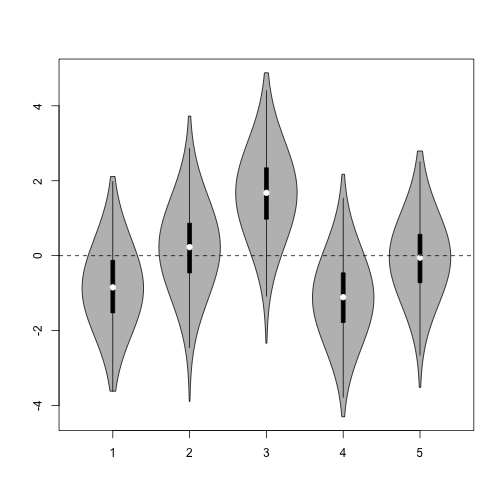

In [17]:
Image("./presentation-figure/unnamed-chunk-1-1.png")

We can see that the lever we really want to be pulling is lever #3, but in practice, we don't know this, and we have to use bandit algorithms to figure it out.

I have coded up an implement of the simple $\epsilon$-greedy bandit algorithm, which you can find in `presentation.Rpres` (it is a plaintext file, so you can open it up with no problems).

Shown below is this algorithm run with various settings of $\epsilon$, where $\epsilon \in \{0.1, 0.01, 0.0, 1.0\}$. $\epsilon = 0.0$ is a special case where we don't do any exploration, and $\epsilon = 1.0$ is a baseline where we always randomly pick levers (we would expect this to perform the worst). We run each setting of $\epsilon$ 30 times and average the corresponding curve.

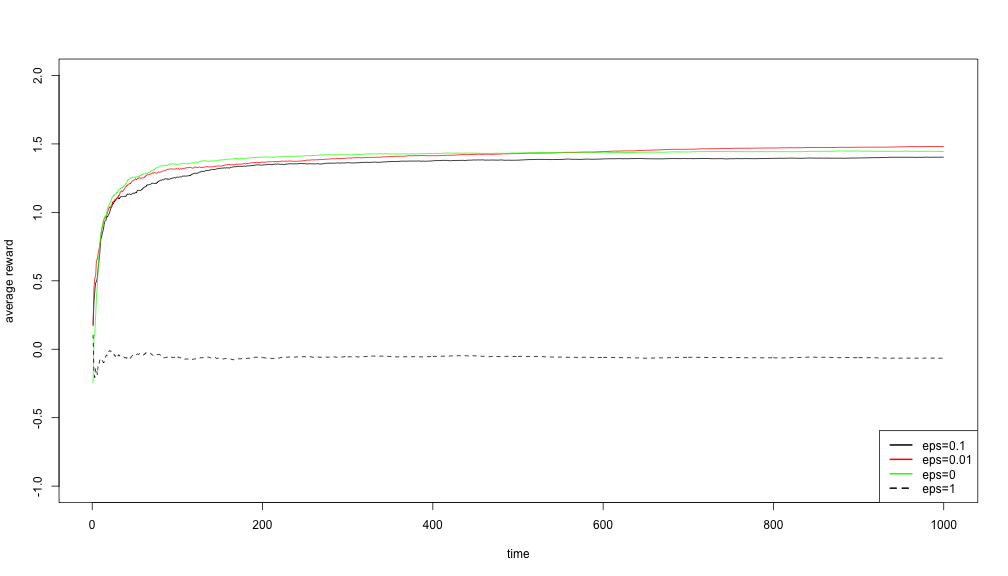

In [16]:
Image("./presentation-figure/unnamed-chunk-4-1.png", width=700)

As we can see, $\epsilon = 0.01$ (shown in red) has managed to achieve a slightly higher reward over the long run.

### Thompson sampling

Now we introduce Thompson sampling, which is a more sophisticated (and Bayesian) approach for determining which lever we should pull. Unlike the simple algorithm we played with earlier, we will see that this method has a natural way of also encoding the 'uncertainty' that is associated with the reward distribution of each lever.

First, let $\mu_{i}$ denote the mean reward of arm $i$. We can imagine that each arm $i$ draws a reward from a probability distribution $p(r \ | \ \mu_{i} = \theta)$. As we mentioned earlier, we know these $\mu_{i}$'s for our dummy example but we won't know them in practice!

It would be nice to know $p(\mu_{i} = \theta \ | \ R)$; that is, what is the probability the mean reward of arm $i$ is $\theta$ given we have observed rewards $R$?

We can express this in terms of Bayes' rule:
$$posterior \propto likelihood \times prior$$
$$p(\mu_{i} = \theta \ | \ R) \propto p(R \ | \ \mu_{i} = \theta) \times p(\mu_{i} = \theta)$$

The LHS of the expression is proportional to the RHS up to a normalising constant, which may be very hard to compute. However, if we make use of [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior) and make certain assumptions about the distribution the rewards are sampled from (that is, the term $p(R \ | \ \mu_{i} = \theta)$) then we can compute the posterior in closed form, based on samples (i.e. observed data) from $p(R \ | \ \mu_{i} = \theta)$

**Bernoulli case**

As an example, let us consider a very simple bandit problem where we have one lever, and it gives us a binary reward (either 0 or 1). Concretely, we observe simple one reward $r \sim Bernoulli(r; \theta)$, and $Bernoulli(r; \theta)$ is the likelihood (which we can sample from by pulling the lever, but we don't know the exact distribution). Now suppose we also have some prior on $\theta$ that is $Beta(\theta; \alpha, \beta)$; we could choose $\alpha = \beta = 1$, which is uniform between 0 and 1 (see [this](http://alliance.seas.upenn.edu/~cis520/wiki/images/beta-distributions.png) for a visualisation). Then, the posterior becomes:

$$p(\mu = \theta \ | \ r) = Beta(\theta; \alpha + r, \beta + 1 - r)$$

Now suppose we observe multiple rewards $R_{n} = \{r_{i}\}_{i=1}^{n}$ from pulling the lever $n$ times. The posterior then becomes:

$$p(\mu = \theta \ | \ R_{n}) = Beta(\theta; \alpha + S_{n}, \beta + F_{n}),$$

where $S_{n} = \sum_{i=1}^{n} 1_{r_{i} = 1}$ (the number of ones we have observed) and $F_{n} = \sum_{i=1}^{n} 1_{r_{i} \neq 1}$ (the number of zeros we have observed).

If we have multiple arms, we maintain a posterior like this for each arm.

Before presenting the presenting the algorithm we use to leverage this posterior, we also show the case in which the rewards are sampled from Gaussians

**Gaussian case**

Suppose we observe rewards $R_{n} = \{r_{i}\}_{i=1}^{n}$, where $r_{i} \sim N(\theta, 1)$ (the variance is known, $\theta$ unknown!). Suppose our prior is also Gaussian, $p(\theta) = N(\theta; 0, 1)$. Then, the posterior after observing $n$ rewards is $p(\theta \ | \ R_{n}) = N(\mu_{n}, \frac{1}{n+1})$, where $\mu_{n}$ is the mean number of rewards from the beginning to time $n$

Now, how do we employ this as an algorithm to figure out the lever to pull? This is illustrated below:

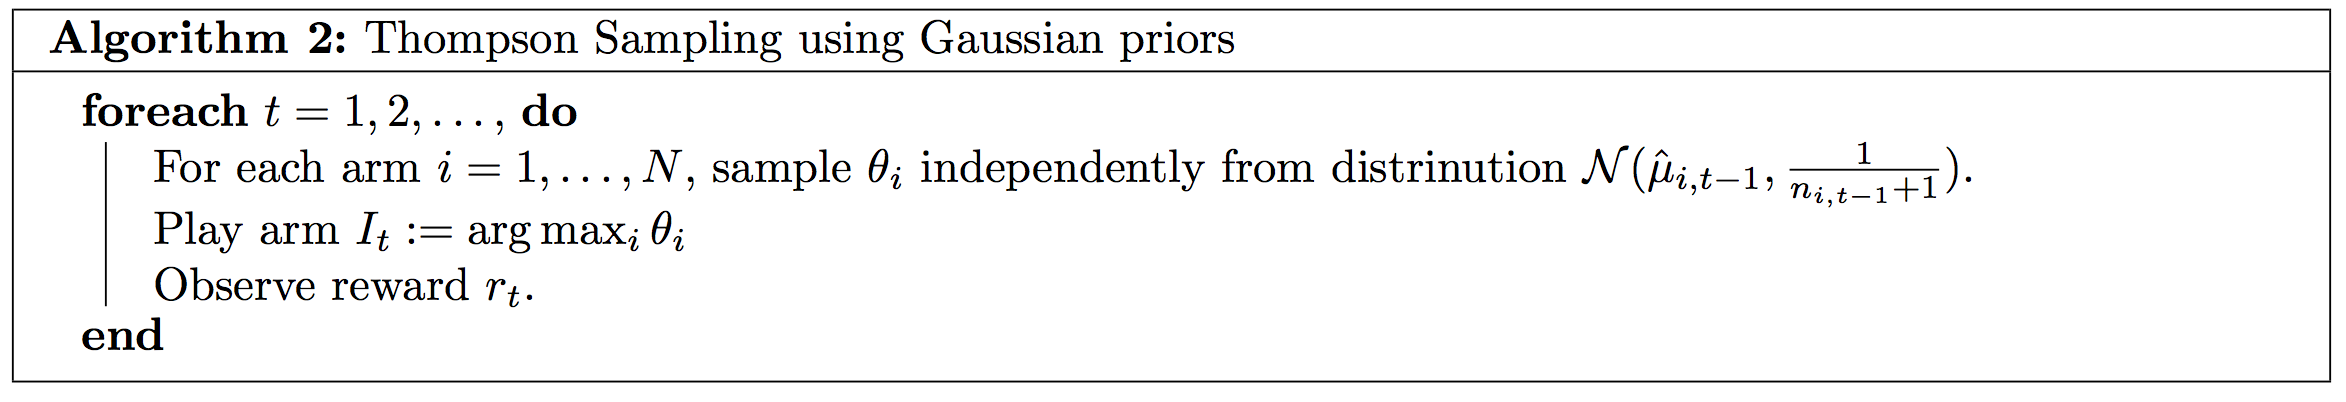

In [18]:
Image("./thompson_gaussian.png")

We can see that this algorithm also encourages exploration, since we're sampling $\theta$ from each of the $k$ posteriors, rather than simply taking the arm whose posterior has the greatest mean.

You can also find code for this algorithm in `presentation.Rpres` as the function `thompson.gauss`.

We run an experiment comparing this algorithm with the same settings of $\epsilon$ for the $\epsilon$-greedy algorithm as we did earlier. We run each experiment 10 times and average the resulting curve.

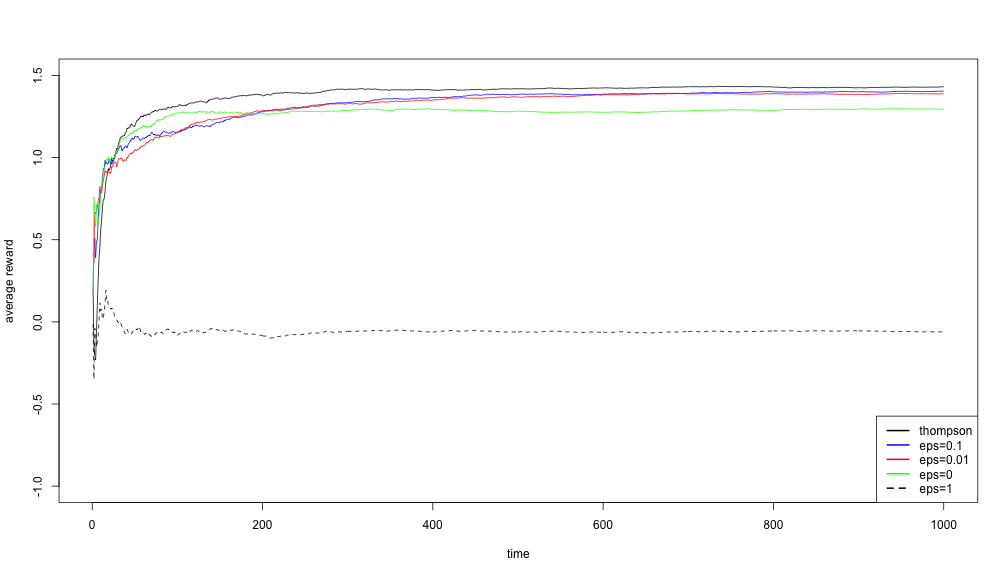

In [21]:
Image("./presentation-figure/unnamed-chunk-6-1.png", width=700)

It seems obvious however that one limitation of this method is that it assumes the likelihood is some simple distribution that is known (we saw two of these just now: Gaussian and Bernoulli). It turns out that we can still use this algorithm even if we make the naive assumption that the likelihood is e.g. Gaussian, but now we cannot call it a 'Bayesian posterior sampling algorithm'. The lecture notes I have linked above do mention this and present a regret bound for any $N$-armed bandit problem.

### Other remarks

- There also exists an algorithm that is 'in-between' what we have talked about: UCB (upper confidence bound). In this algorithm, we estimate an upper bound on the mean reward of an action, which is a measure of the uncertainty/variance in the estimate of its value. You can see an article comparing Thompson and UCB here: http://engineering.richrelevance.com/recommendations-thompson-sampling/

- The simple $\epsilon$-greedy algorithm doesn't encode any 'uncertainty' in estimate of the mean reward like UCB or Thompson sampling does; UCB does it through the upper bound term, and Thompson does it through the posterior, whose variance is known. I could see an easy modification to the $\epsilon$-greedy algorithm however: also keep a running estimate of the variance of the rewards from each arm. The algorithm could be modified so that, if are tied between picking two arms that have the same mean reward, we pick the arm whose variance is smaller.